## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import json
import time
from sklearn.preprocessing import RobustScaler, OneHotEncoder, MinMaxScaler, StandardScaler
# from sklearn.preprocessing import PowerTransform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.cluster import normalized_mutual_info_score
from scipy.stats.stats import pearsonr, spearmanr

from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats
from numpy import mean
from numpy import std
import math

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
print(tf.__version__)
# from tensorflow import keras

from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow import feature_column
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.regularizers import l1
from keras.constraints import unit_norm
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.models import model_from_json
from collections import OrderedDict
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import mean_squared_error
from math import log
import category_encoders as ce
import tensorflow.keras.backend as K
print("GPU Available: ", tf.test.is_gpu_available())

2.3.0
GPU Available:  False


## Helper Methods

In [3]:
output_column = 'LE_bowen_corr(mm)'
def read_data():
        file_path = "/Users/saraawad/Desktop/All_Manual_Daily_Albedo_NDVI_LST_Cleaned.csv"
        df = pd.read_csv(file_path, delimiter=',')

        columnsToDrop = ['Year', 'Month', 'Day', 'Site Id_1', 'Site Id_2', 'Site Id_3',
                        'Site Id_4', 'Site Id_5', 'Site Id_6','Vegetation', 'Latitude', 'Longitude', 'Climate',
                        'G','G-1','G-2','G-3','G-4','G-5',
                        'Climate_1', 'Climate_2', 'Climate_3',
                        'Latitude_1','Latitude_2', 'Latitude_3', 'Latitude_4', 'Latitude_5',
                        'Latitude_6','Longitude_1', 'Longitude_2', 'Longitude_3', 'Longitude_4',
                        'Longitude_5', 'Longitude_6',
                        'H', 'H_bowen_corr', 'H_bowen_corr-1', 'H_bowen_corr-2', 'H_bowen_corr-3', 'H_bowen_corr-4',
                        'H_bowen_corr-5', 'C_BOWENS',
                        'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5',
                        'LE', 'LE_bowen_corr',
                        'Elevation(m)_1','Elevation(m)_2', 'Elevation(m)_3', 'Elevation(m)_4',
                        'Elevation(m)_5', 'Elevation(m)_6',
                        'ETo', 'EToF', 'ETr', 'ETrF', 'ETo', 'SW_IN']

        df = df.drop(columnsToDrop, axis = 1)
        df.dropna(inplace=True)

        df = df[df[output_column].between(1, 15)]

        #Generate 5 lags
#         lagsForColumns = ["SW_IN", "WS", "RH", "TA", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
#         df = generate_lags(df, lagsForColumns)
#         df.dropna(inplace=True)

        #Binary Encode Site Id
        df = binary_encode_column(df, "Site Id")

        #Drop columns
        df.drop(columns=['Site Id_0'], inplace=True)
        return df

def binary_encode_column(df, columnToEncode):
        encoder = ce.BinaryEncoder(cols=[columnToEncode])
        df_encoder = encoder.fit_transform(df[columnToEncode])
        df = pd.concat([df, df_encoder], axis=1)
        return df

def generate_lags_for(df, column, lags_count): 
            for i in range(lags_count):
                lag_name = column + "-" + str(i + 1)
                df[lag_name] = df[column].shift(i + 1)
            return df

def generate_lags(df, lagsForColumns, lagsCount):
        for k in range(len(lagsForColumns)):
            col = lagsForColumns[k]
            if col in df.columns:
                df = generate_lags_for(df, col, lagsCount)
        return df
    
    
def split_train_test(df, TRAIN_RATIO, TEST_RATIO):
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    Y_train = pd.DataFrame()
    Y_test = pd.DataFrame()
    
    unique_sites = df["Site Id"].unique()
    print("Number of sites:", len(unique_sites))

    for site in unique_sites:
        df_site = df[df["Site Id"] == site]
        X = df_site
        train_index = int(X.shape[0] * TRAIN_RATIO)
        test_index = int(X.shape[0] * (TRAIN_RATIO + TEST_RATIO))

        X_train = X_train.append(X[:train_index], ignore_index = True)
        X_test = X_test.append(X[train_index:], ignore_index = True)
        Y_train = Y_train.append(X[:train_index], ignore_index = True)
        Y_test = Y_test.append(X[train_index:], ignore_index = True)
   
    Y_train = Y_train[[output_column]]
    Y_test = Y_test[[output_column]]
   
    X_train = X_train.drop([output_column], axis = 1)
    X_test = X_test.drop([output_column], axis = 1)
   
    return X_train, Y_train, X_test, Y_test

In [4]:
df = read_data()

columnsToDrop = ['WS-1', 'WS-2', 'WS-3', 'WS-4','WS-5',
                 'RH-1', 'RH-2', 'RH-3', 'RH-4', 'RH-5',
                 'TA-1','TA-2', 'TA-3', 'TA-4', 'TA-5',
                 'EEflux LST-1', 'EEflux LST-2', 'EEflux LST-3', 'EEflux LST-4',
                 'EEflux LST-5', 'EEflux NDVI-1', 'EEflux NDVI-2',
                 'EEflux NDVI-3', 'EEflux NDVI-4', 'EEflux NDVI-5',
                 'EEflux Albedo-1', 'EEflux Albedo-2', 'EEflux Albedo-3',
                 'EEflux Albedo-4', 'EEflux Albedo-5']
df = df.drop(columnsToDrop, axis = 1)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.columns

Index(['Site Id', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'RH', 'TA', 'LE_bowen_corr(mm)',
       'EEflux LST', 'EEflux NDVI', 'EEflux Albedo', 'Site Id_1', 'Site Id_2',
       'Site Id_3', 'Site Id_4', 'Site Id_5'],
      dtype='object')

# Plots

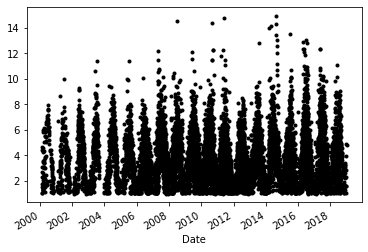

In [5]:
from matplotlib import pyplot as plt
df['LE_bowen_corr(mm)'].plot(style='k.')
plt.show()

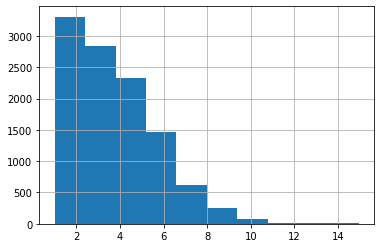

In [6]:
df['LE_bowen_corr(mm)'].hist()

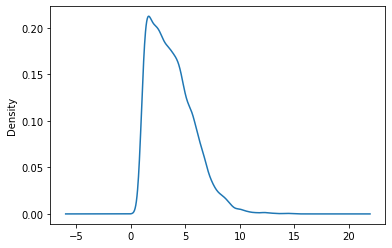

In [7]:
df['LE_bowen_corr(mm)'].plot(kind='kde')
plt.show()

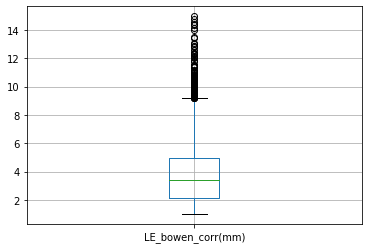

In [8]:
df[['LE_bowen_corr(mm)']].boxplot()
plt.show()

# Lag Scatter Plots

Time series modeling assumes a relationship between an observation and the previous observation. Previous observations in a time series are called lags, with the observation at the previous time step called lag1,
the observation at two time steps ago lag=2, and so on. A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot. Pandas has a built-in function for exactly this called the lag plot. 

It plots the observation at time t on the x-axis and the lag=1 observation (t-1) on the y-axis.
<ul>
<li>If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.</li>
<li>If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.</li>
<li>Either relationship is good as they can be modeled.</li>
</ul>

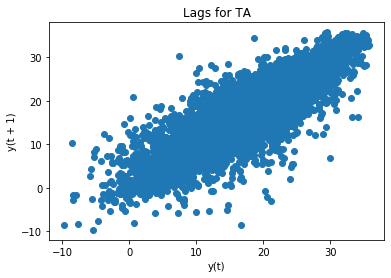

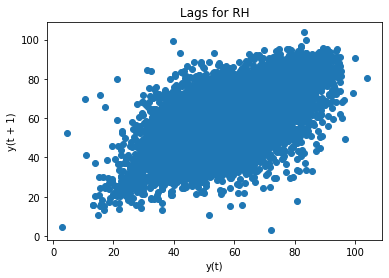

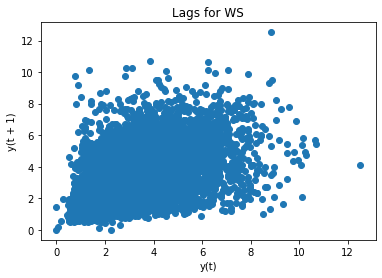

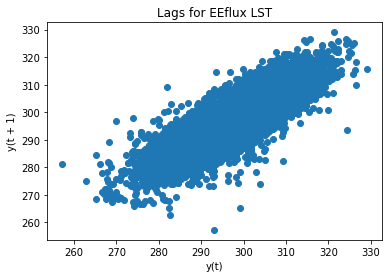

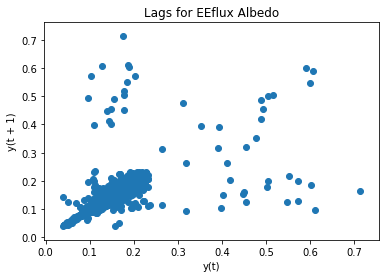

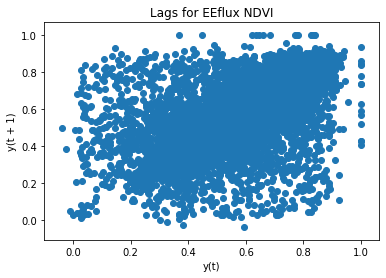

In [25]:
from pandas.plotting import lag_plot

columns = ['TA', 'RH', 'WS', 'EEflux LST', 'EEflux Albedo', 'EEflux NDVI']
for column in columns:
    lag_plot(df[column])
    plt.title('Lags for ' + column)
    plt.show()

We have a positive correlation ordered as such for the following:
    <ul>
    <li>TA and its first lags</li>
    <li>EEflux LST and its first lags</li>
    <li>RH and its first lags</li>
    </ul>

Lags plot for  TA


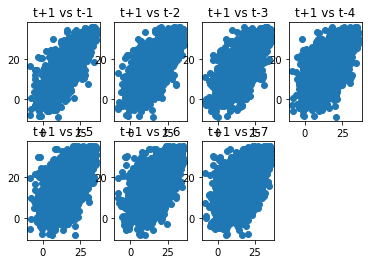

-------------------------------------------

Lags plot for  RH


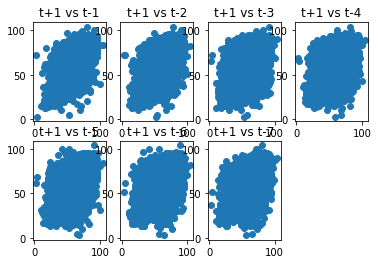

-------------------------------------------

Lags plot for  WS


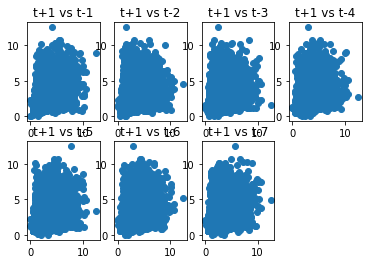

-------------------------------------------

Lags plot for  EEflux LST


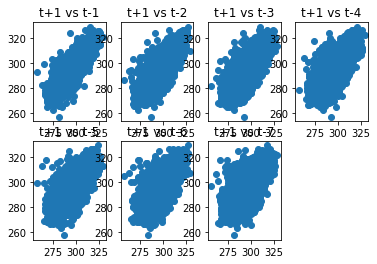

-------------------------------------------

Lags plot for  EEflux Albedo


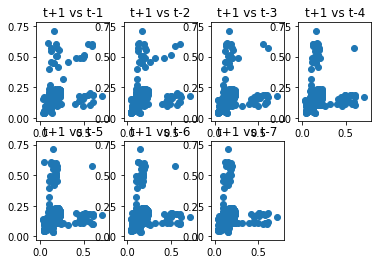

-------------------------------------------

Lags plot for  EEflux NDVI


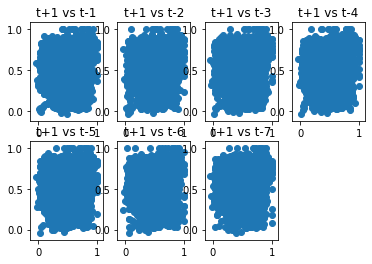

-------------------------------------------



In [70]:
def generate_lags_for(df, column, lags_count): 
    for i in range(lags_count):
        lag_name = column + "-" + str(i + 1)
        df[lag_name] = df[column].shift(i + 1)
    return df

def generate_lags(df, lagsForColumns, lagsCount):
    for k in range(len(lagsForColumns)):
        col = lagsForColumns[k]
        if col in df.columns:
            df = generate_lags_for(df, col, lagsCount)
    return df


def plot_lags(columns):
    for column in columns:
        print("Lags plot for ", column)
        plt.figure(1)
        for i in range(1,(lags+1)):
                ax = plt.subplot(240 + i)
                ax.set_title('t+1 vs t-' + str(i))
                plt.scatter(x=df[column].values, y=df[column+'-'+str(i)].values)
        plt.show()
        print("-------------------------------------------")
        print()

lags = 7
lagsForColumns = ["TA", "RH","WS", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
df = generate_lags(df, lagsForColumns, lags)
df.dropna(inplace=True)

# print(df.columns)

plot_lags(lagsForColumns)

# Autocorrelation Plots

We can quantify the strength and type of relationship between observations and their lags. In statistics, this is called correlation, and when calculated against lag values in time series, it is called autocorrelation (self-correlation). A correlation value calculated between two groups of numbers, such as observations and their lag=1 values, results in a number between -1 and 1.

The sign of this number indicates a negative or positive correlation respectively. A value close to zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation. Correlation values, called correlation coefficients, can be calculated for each observation and
different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag. This type of plot is called an autocorrelation plot and Pandas provides this capability built in, called the autocorrelation plot() function

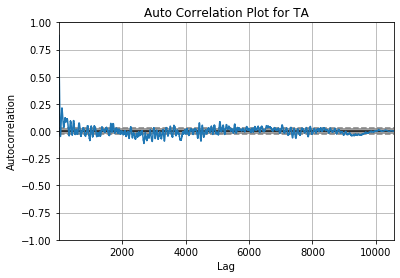

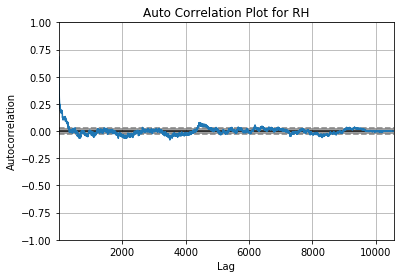

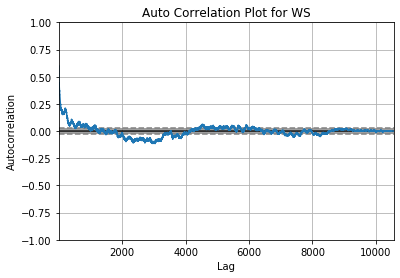

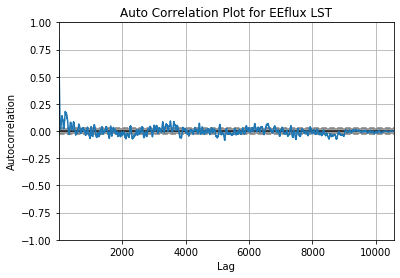

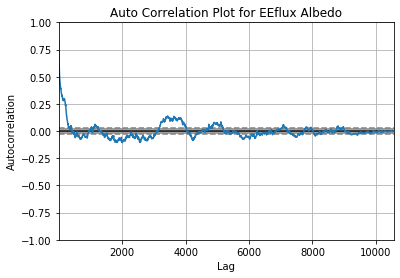

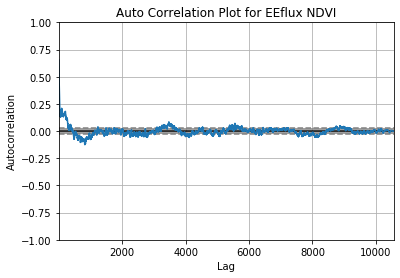

In [73]:
from pandas.plotting import autocorrelation_plot

columns = ["TA", "RH","WS", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
for column in columns:
    autocorrelation_plot(df[column])
    plt.title('Auto Correlation Plot for ' + column)
    plt.show()

The resulting plot shows lag along the x-axis and the correlation on the y-axis. Dotted lines are provided that indicate any correlation values above those lines are statistically significant (meaningful)

Autocorrelation Function (ACF). The plot summarizes the correlation of an obser- vation with lag values. The x-axis shows the lag and the y-axis shows the correlation coefficient between -1 and 1 for negative and positive correlation.

The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling
    
The correlation statistics can also help to choose which lag variables will be useful in a model and which will not. Interestingly, if all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable.

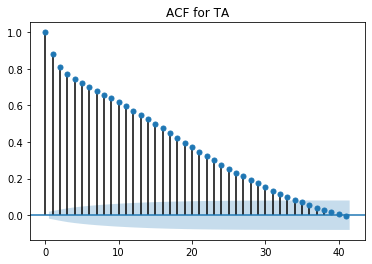

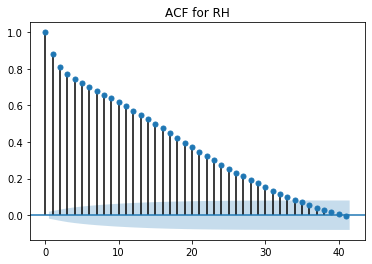

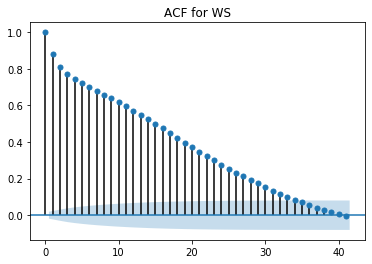

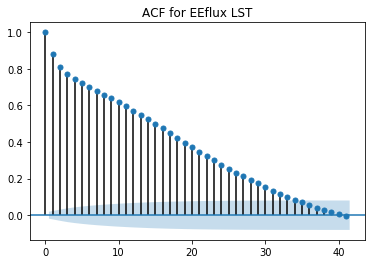

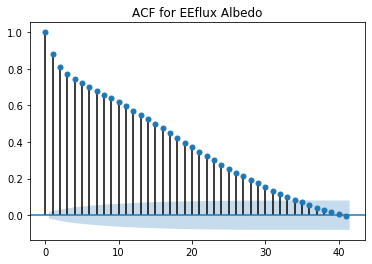

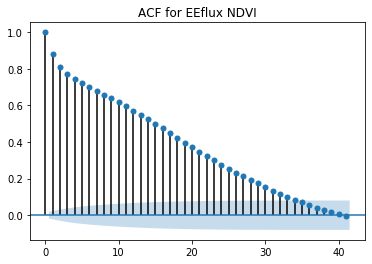

In [88]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

columns = ["TA", "RH","WS", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
for column in columns:
    plot_acf(df['TA'])
    plt.title('ACF for ' + column)
    plt.show()

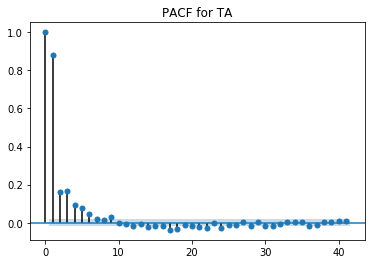

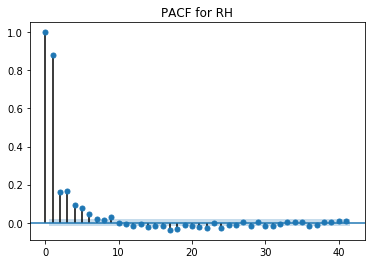

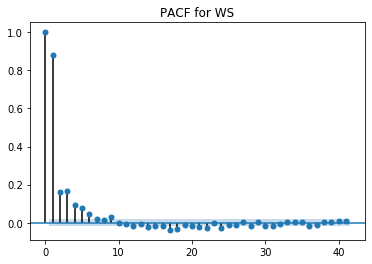

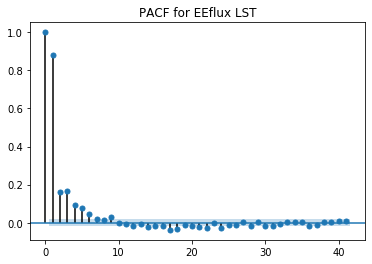

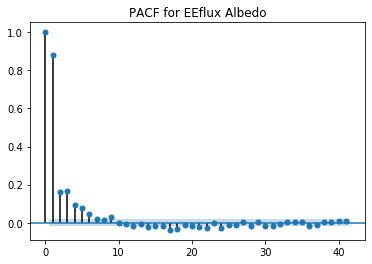

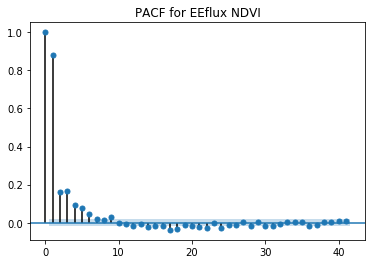

In [90]:
columns = ["TA", "RH","WS", "EEflux LST", "EEflux Albedo", "EEflux NDVI"]
for column in columns:
    plot_pacf(df['TA'])
    plt.title('PACF for ' + column)
    plt.show()

In [74]:
df.columns

Index(['Site Id', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Vegetation_1',
       'Vegetation_2', 'Vegetation_3', 'WS', 'RH', 'TA', 'LE_bowen_corr(mm)',
       'EEflux LST', 'EEflux NDVI', 'EEflux Albedo', 'Site Id_1', 'Site Id_2',
       'Site Id_3', 'Site Id_4', 'Site Id_5', 'TA-1', 'TA-2', 'TA-3', 'TA-4',
       'TA-5', 'TA-6', 'TA-7', 'TA-8', 'TA-9', 'TA-10', 'RH-1', 'RH-2', 'RH-3',
       'RH-4', 'RH-5', 'RH-6', 'RH-7', 'WS-1', 'WS-2', 'WS-3', 'WS-4', 'WS-5',
       'WS-6', 'WS-7', 'EEflux LST-1', 'EEflux LST-2', 'EEflux LST-3',
       'EEflux LST-4', 'EEflux LST-5', 'EEflux LST-6', 'EEflux LST-7',
       'EEflux Albedo-1', 'EEflux Albedo-2', 'EEflux Albedo-3',
       'EEflux Albedo-4', 'EEflux Albedo-5', 'EEflux Albedo-6',
       'EEflux Albedo-7', 'EEflux NDVI-1', 'EEflux NDVI-2', 'EEflux NDVI-3',
       'EEflux NDVI-4', 'EEflux NDVI-5', 'EEflux NDVI-6', 'EEflux NDVI-7'],
      dtype='object')

# Pearson Correlation Coefficient

This produces a number to summarize how correlated two variables are between -1 (negatively correlated) and +1 (positively correlated) with small values close to zero indicating low correlation and high values
above 0.5 or below -0.5 showing high correlation.
Correlation can be calculated easily using the corr() function2 on the DataFrame of the
lagged dataset

In [76]:
df[['TA', 'TA-1', 'TA-2', 'TA-3', 'TA-4',
       'TA-5', 'TA-6', 'TA-7', 'TA-8', 'TA-9', 'TA-10']].corr()

TA      TA-1      TA-2      TA-3      TA-4      TA-5      TA-6  \
TA     1.000000  0.878832  0.808843  0.774758  0.747313  0.725146  0.703562   
TA-1   0.878832  1.000000  0.878799  0.808779  0.774713  0.747285  0.725089   
TA-2   0.808843  0.878799  1.000000  0.878783  0.808763  0.774706  0.747279   
TA-3   0.774758  0.808779  0.878783  1.000000  0.878774  0.808759  0.774728   
TA-4   0.747313  0.774713  0.808763  0.878774  1.000000  0.878773  0.808758   
TA-5   0.725146  0.747285  0.774706  0.808759  0.878773  1.000000  0.878761   
TA-6   0.703562  0.725089  0.747279  0.774728  0.808758  0.878761  1.000000   
TA-7   0.680157  0.703534  0.725100  0.747309  0.774741  0.808762  0.878775   
TA-8   0.657582  0.680127  0.703525  0.725094  0.747303  0.774737  0.808750   
TA-9   0.640294  0.657569  0.680154  0.703573  0.725121  0.747318  0.774773   
TA-10  0.619063  0.640261  0.657596  0.680218  0.703601  0.725131  0.747374   

           TA-7      TA-8      TA-9     TA-10  
TA     0.680157  0.657582  0.640294  0.619063  
TA-1   0.703534  0.680127  0.657569  0.640261  
TA-2   0.725100  0.703525  0.680154  0.657596  
TA-3   0.747309  0.725094  0.703573  0.680218  
TA-4   0.774741  0.747303  0.725121  0.703601  
TA-5   0.808762  0.774737  0.747318  0.725131  
TA-6   0.878775  0.808750  0.774773  0.747374  
TA-7   1.000000  0.878772  0.808775  0.774807  
TA-8   0.878772  1.000000  0.878774  0.808767  
TA-9   0.808775  0.878774  1.000000  0.878790  
TA-10  0.774807  0.808767  0.878790  1.000000